In [28]:
import legacy.eigenstate_generator as eig
import utils.cs_vqe_tools as c
import legacy.cs_vqe_ansatz as c_anz
import utils.qonversion_tools as qonvert
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median
import utils.linalg_tools as la

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.algorithms import VQE
from qiskit import Aer

In [15]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069374+0j) [] +
(-0.025810254414814025+0j) [X0 X1 Y2 Y3] +
(-0.012799934786437407+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839897472+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.01279993478643741+0j) [X0 X1 X3 X4] +
(-0.025159645839897472+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.017114528821774874+0j) [X0 X1 Y4 Y5] +
(-0.000989104910363448+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.000989104910363448+0j) [X0 X1 X5 X6] +
(-0.05469856574684985+0j) [X0 X1 Y6 Y7] +
(0.025810254414814025+0j) [X0 Y1 Y2 X3] +
(0.012799934786437407+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839897472+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.01279993478643741+0j) [X0 Y1 Y3 X4] +
(-0.025159645839897472+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.017114528821774874+0j) [X0 Y1 Y4 X5] +
(0.000989104910363448+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.000989104910363448+0j) [X0 Y1 Y5 X6] +
(0.05469856574684985+0j) [X0 Y1 Y6 X7] +
(0.0025779051794092497+0j) [X0 Z1 X2] +
(0.004766148105680577+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307293+0j) [X0 Z1 X2 X3 Z4 Z

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [16]:
#import itertools
#bin_strings = [''.join(s) for s in list(itertools.product(['0','1'], repeat=num_qubits))]

In [17]:
#for b in bin_strings:
#    hf=np.array([0 for i in range(2**num_qubits)])
#    hf[eig.bin_to_int(b)] = 1
#    psi = LinearQubitOperator(ucc_q).matvec(hf)
#    psi_conj = np.conjugate(psi)
#    psi = psi/np.sqrt((psi_conj.dot(psi)))
#    psi_conj = np.conjugate(psi)
#    expect = eig.expectation(ham_q, psi, num_qubits)
#    if expect < -3:
#        print(b, psi_conj.dot(psi), expect)
#print('finished')

In [18]:
ham = qonvert.QubitOperator_to_dict(ham_q, num_qubits)
#anz_terms = list((qonvert.QubitOperator_to_dict(ucc_q, num_qubits)).keys())

#noncontextual hamiltonian
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#contextual hamiltonian
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}

#construct the epistricted model
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
generators = {g:ep_state[0][index] for index, g in enumerate(model[0])}
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
r1 = ep_state[1][0]
r2 = ep_state[1][1]

#reduced hamiltonians
order = [6, 0, 1, 2, 3, 4, 5, 7] #optimal: [6, 4, 0, 2, 3, 1, 5, 7]
ham_red = c.get_reduced_hamiltonians(ham,model,fn_form,ep_state,order)

#rotate the hamiltonians
rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
ham, ham_noncon, ham_context = eig.rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
generators = eig.rotate_operator(rotations, generators)
A = eig.rotate_operator(rotations, A)
ucc = eig.rotate_operator(rotations, ucc)

In [19]:
print('commuting generators:',generators, '\n')
print('anticommuting generators:',A, '\n')
#print('Minimising configuration:', gs_noncon[1])

commuting generators: {'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': 1.0, 'IIIZIIII': -1.0, 'IIIIZIII': 1.0, 'IIIIIZII': 1.0, 'IIIIIIIZ': 1.0} 

anticommuting generators: {'IZZZZZXI': 0.04017218675220471, 'IIIIIIZI': 0.999192771897168} 



In [20]:
ham_q = qonvert.dict_to_QubitOperator(ham)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context)
initial_state='00010000'

#take expectation value algebraically
psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=16, theta=0, num_qubits=num_qubits, rot=True)
#psi = eig.rotate_state(rotations, psi, num_qubits)
expect = eig.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-3.1428247492681747+0j)
Noncontextual approximation: -3.1428247492681756
Expectation values match? True


In [21]:
qmap = eig.qubit_map('HeH+', num_qubits, rot=True)

In [22]:
qmap_expect=[]
for i in eig.find_eigenstate_indices('00010000', [3, 2, 7]):
    psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=i, theta=0, num_qubits=num_qubits, rot=True)
    expect = eig.expectation(ham_q, psi, num_qubits)
    qmap_expect.append([expect, qmap[i]])

In [23]:
sorted(qmap_expect, key=lambda x:x[0])

[[(-3.1428247492681747+0j), [(16, '00010000'), (18, '00010010')]],
 [(-3.1413189795666803+0j), [(32, '00100000'), (34, '00100010')]],
 [(-2.8863005893355678+0j), [(0, '00000000'), (2, '00000010')]],
 [(-2.851547766868846+0j), [(48, '00110000'), (50, '00110010')]],
 [(-0.5704922158862756+0j), [(33, '00100001'), (35, '00100011')]],
 [(-0.5268113901337862+0j), [(17, '00010001'), (19, '00010011')]],
 [(-0.2914727856339091+0j), [(49, '00110001'), (51, '00110011')]],
 [(-0.2595354477557104+0j), [(1, '00000001'), (3, '00000011')]]]

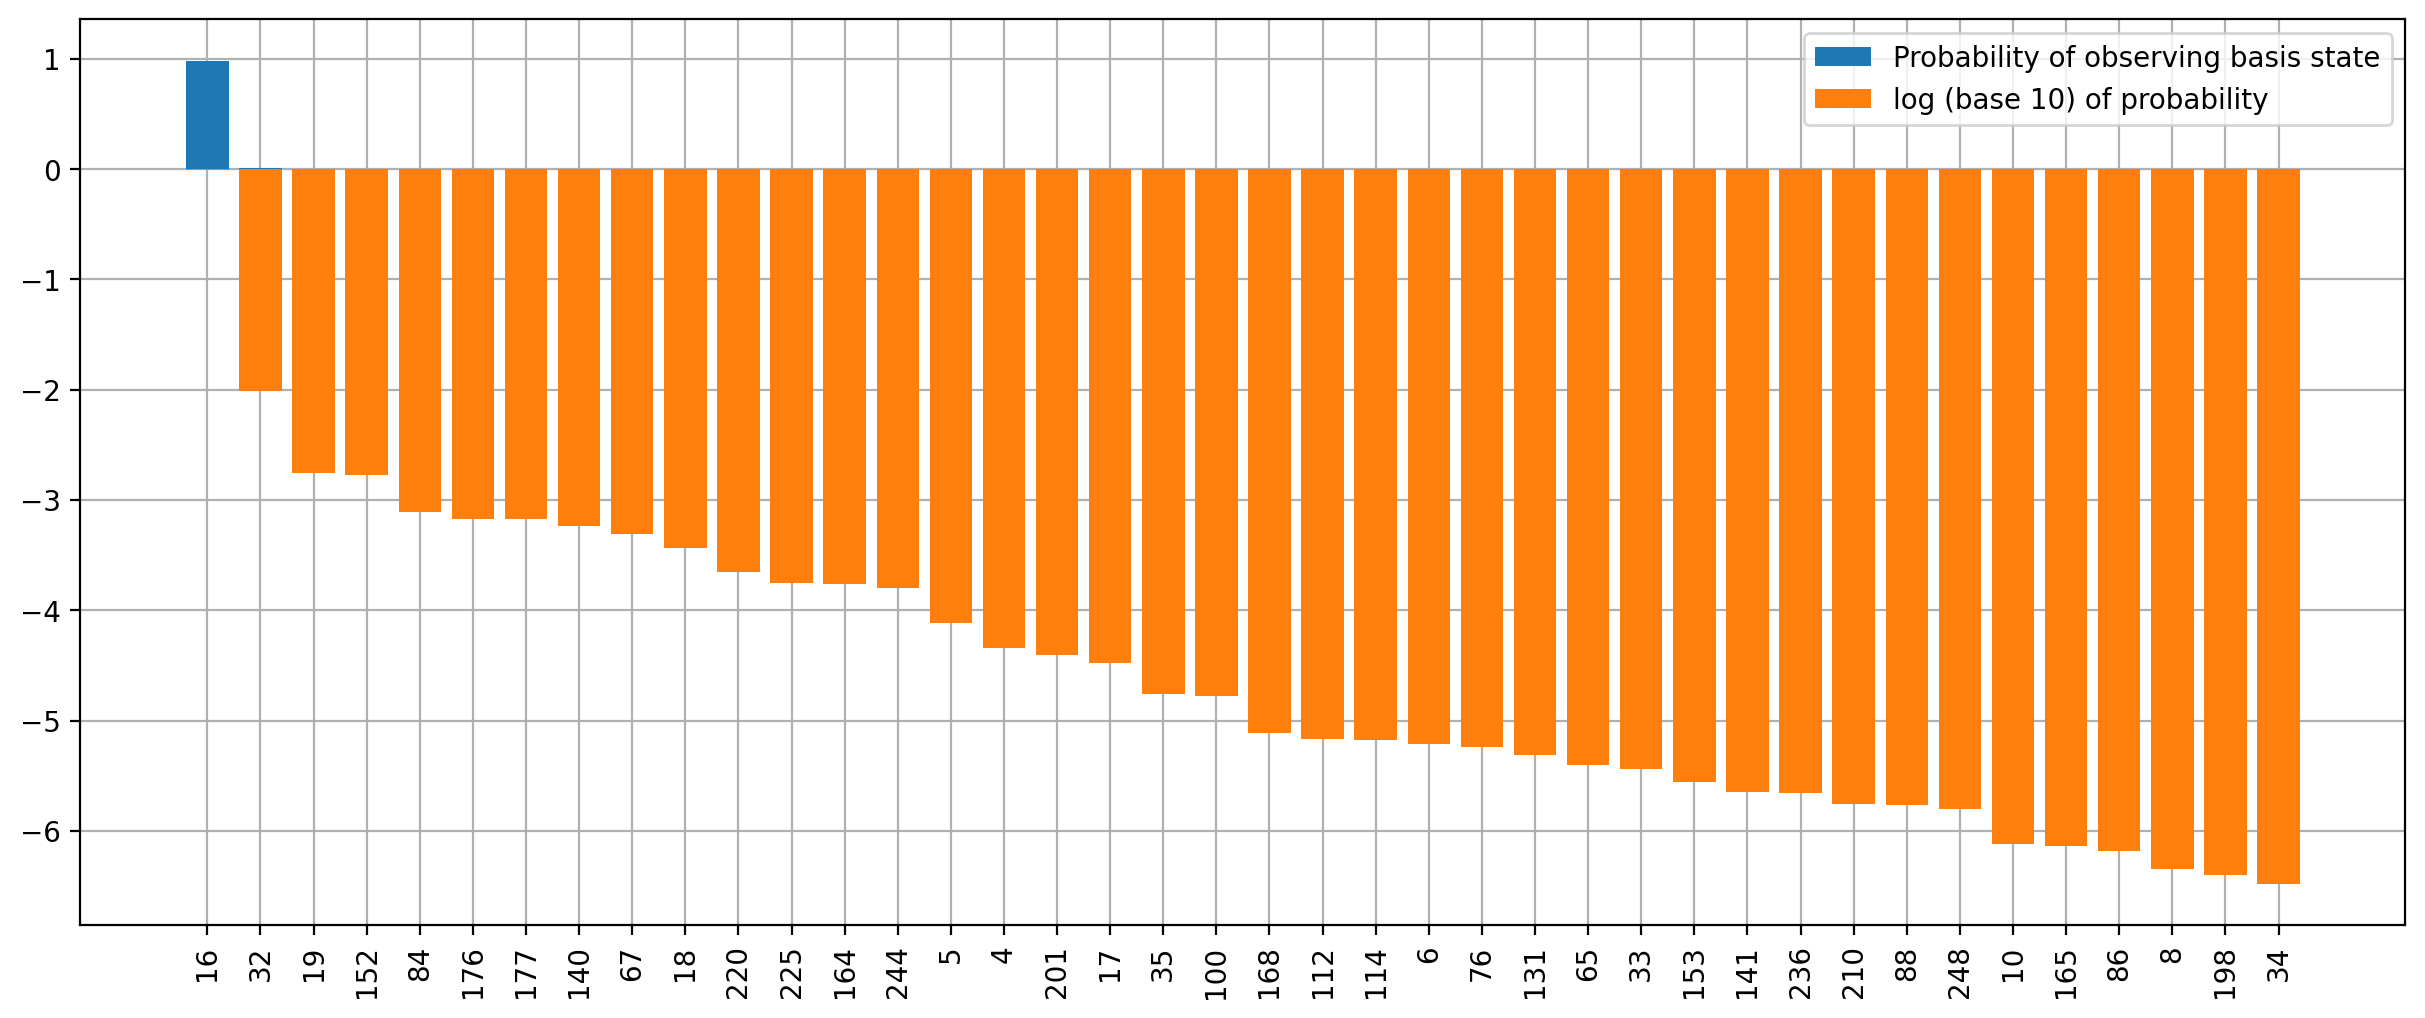

In [24]:
gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())
true_gs = gs[0]

amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = sorted([(str(index), a) for index, a in enumerate(amp_list) if a > 10**-7], key=lambda x:x[1])
sig_amp_list.reverse()

XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]
Y_log = [np.log10(a) for a in Y]

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=200)

plt.grid(zorder=0)
plt.bar(X, Y, zorder=2, label='Probability of observing basis state')
plt.bar(X, Y_log, zorder=3, label = 'log (base 10) of probability')
plt.xticks(rotation=90)
plt.legend()
plt.show()

/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


Text(0.5, 0, 'No. qubits in VQE simulation')

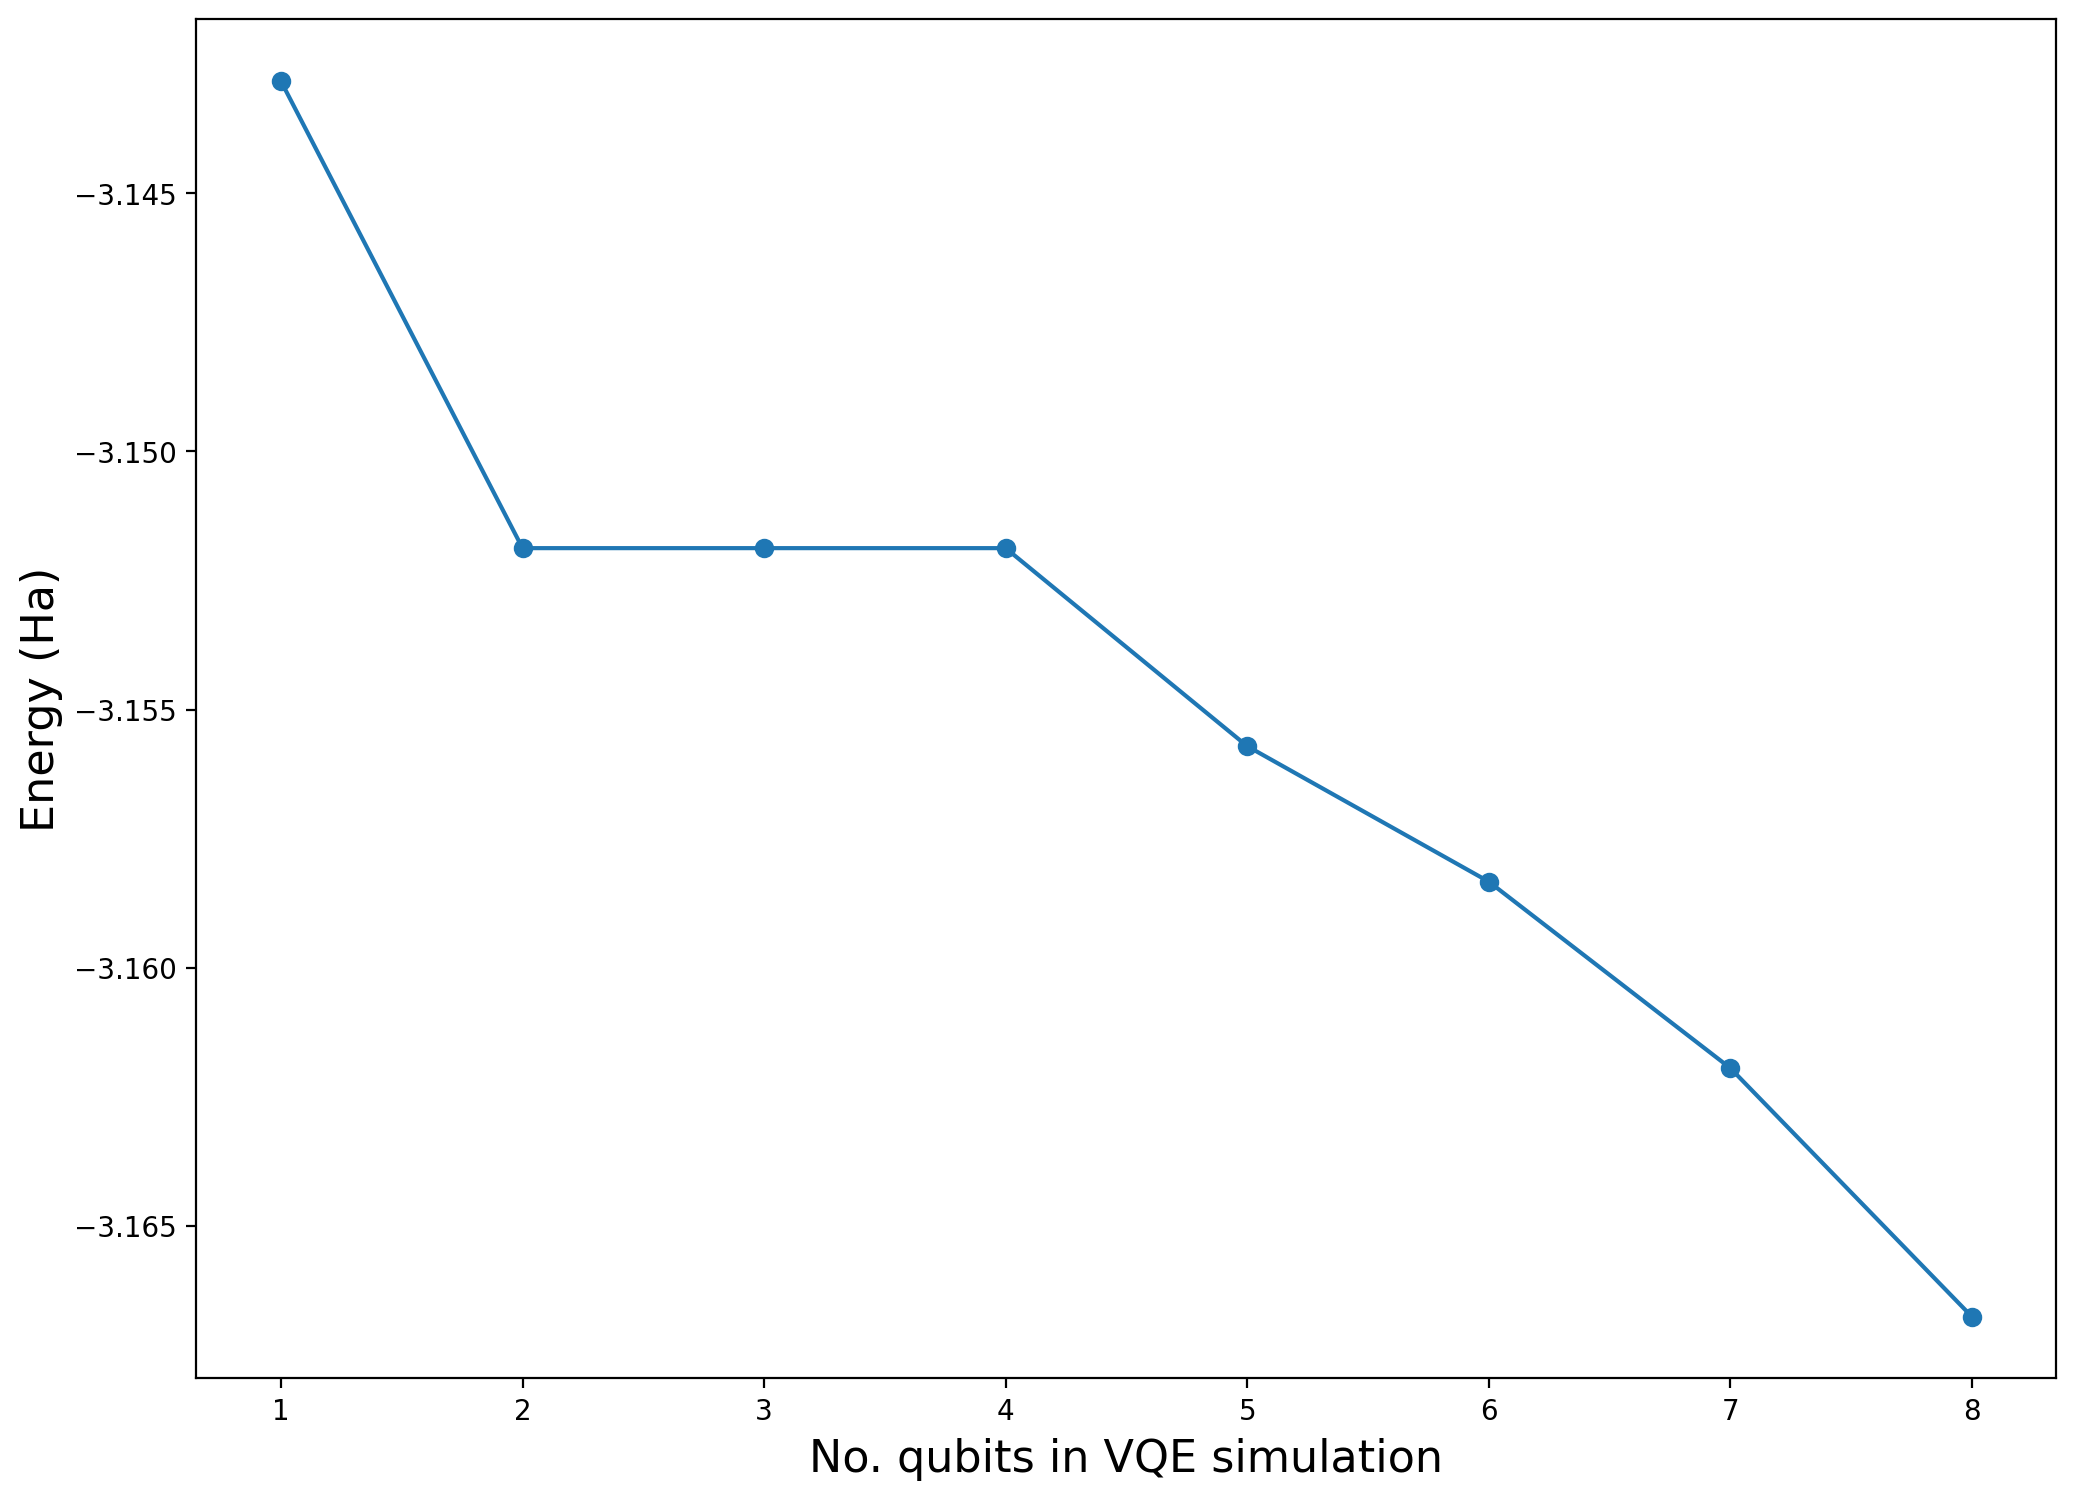

In [25]:
X=range(1, 9)
Y=[]
for no_q in X:
    ham_red_q = qonvert.dict_to_QubitOperator(ham_red[no_q-1])
    gs_red = get_ground_state(get_sparse_operator(ham_red_q, no_q).toarray())
    Y.append(gs_red[0])

figure(figsize=(12, 9), dpi=200)
plt.plot(X, Y)
plt.scatter(X, Y)
plt.ylabel('Energy (Ha)',fontsize=16)
plt.xlabel('No. qubits in VQE simulation',fontsize=16)

[] []


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


['ZIIIIIII'] [0]
['IZIIIIII', 'ZIIIIIII'] [1, 0]
['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [2, 1, 0]
['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 2, 1, 0]
['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 3, 2, 1, 0]
['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 4, 3, 2, 1, 0]
['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [7, 5, 4, 3, 2, 1, 0]


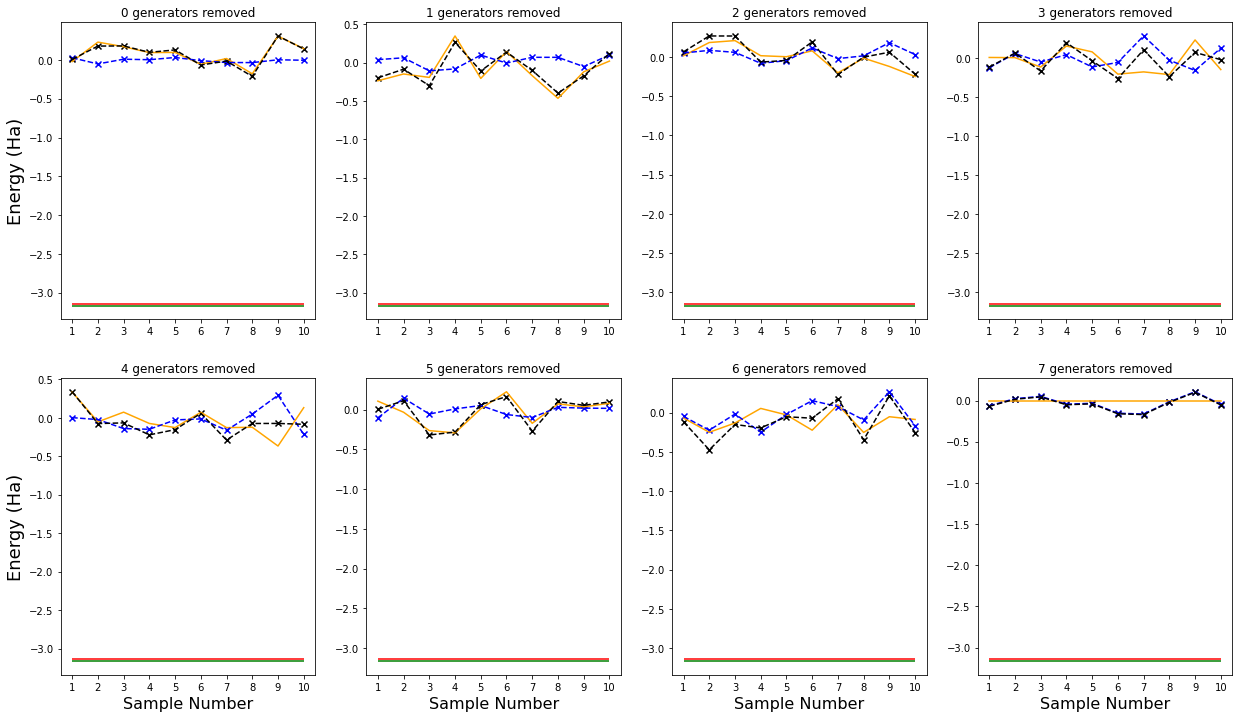

In [30]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10
#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
molecule='HeH+'
I_op = openfermion.ops.QubitOperator.identity()
A_op = qonvert.dict_to_QubitOperator(A)
A_array = get_sparse_operator(A_op, n_qubits=8).toarray()
projector = get_sparse_operator((A_op+I_op)/2, n_qubits=8).toarray()

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
#grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)

    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = eig.random_vector(2**len(removed_index))
        rand_vec = sorted([eig.random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)
        
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        #expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
        #                                                          r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
        #                                                          Z_indices=Z_indices,rot=True)
        
        random_vec = la.random_complex_vector(2**8)
        psi = np.dot(projector, random_vec)
        psi_conj = np.conjugate(psi)
        norm = np.sqrt(np.dot(psi_conj, psi))
        psi = psi/norm
        psi_conj = np.conjugate(psi)
        
        expect_noncon = la.expectation(new_ham_noncon_q, psi, 8)
        expect_context = la.expectation(new_ham_context_q, psi, 8)
        
        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [31]:
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits+1)

anz = c_anz.construct_ansatz(init_state=[4], paulis=list(ucc.keys()))
#anz.x(4)
#anz += c_anz.exp_P('IIIZYIZZI', rot=np.pi/2)

##store parity in auxiliary qubit (8) via CNOT cascade
#anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
##move into +1-eigenstate
#anz.cry(2*t2+0.2, 8, 1)
#anz.x(8)
#anz.cry(2*t2+0.2, 8, 1)
#anz.x(8)
##reverse CNOT cascade
#anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
#anz.x(1)

anz.measure_all()
print(anz.draw())
backend = BasicAer.get_backend('qasm_simulator')
job = execute(anz, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

              ░ ┌─────┐┌───┐                                           ┌───┐»
   q_0: ──────░─┤ SDG ├┤ H ├──■─────────────────────────────────────■──┤ H ├»
              ░ └─────┘└───┘┌─┴─┐                                 ┌─┴─┐└───┘»
   q_1: ──────░─────────────┤ X ├──■───────────────────────────■──┤ X ├─────»
              ░  ┌───┐      └───┘┌─┴─┐                       ┌─┴─┐├───┤     »
   q_2: ──────░──┤ H ├───────────┤ X ├──■─────────────────■──┤ X ├┤ H ├─────»
              ░  └───┘           └───┘  │                 │  └───┘└───┘     »
   q_3: ──────░─────────────────────────┼─────────────────┼─────────────────»
        ┌───┐ ░                         │                 │                 »
   q_4: ┤ X ├─░─────────────────────────┼─────────────────┼─────────────────»
        └───┘ ░                         │                 │                 »
   q_5: ──────░─────────────────────────┼─────────────────┼─────────────────»
              ░                         │                 │     

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(αβγ), Parameter(αβδ), Parameter(αβε), Parameter(αβζ), Parameter(αβη), Parameter(αβθ), Parameter(αβι), Parameter(αβκ), Parameter(αβλ), Parameter(αβμ), Parameter(αβν), Parameter(αβξ), Parameter(αβο), Parameter(αβπ), Parameter(αβρ), Parameter(αβς), Parameter(αβσ), Parameter(αβτ), Parameter(αβυ), Parameter(αβφ), Parameter(αβχ), Parameter(αβψ), Parameter(αβω), Parameter(αγδ), Parameter(αγε), Parameter(αγζ), Parameter(αγη), Parameter(αγθ), Parameter(αγι), Parameter(αγκ), Parameter(αγλ), Parameter(αγμ), Parameter(αγν), Parameter(αγξ), Parameter(αγο), Parameter(αγπ)])]'

In [71]:
removed_generators = ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII','IIIZIIII','IIIIZIII','IIIIIZII', 'IIIIIIIZ']
new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

slsqp = SLSQP(maxiter=10000)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits)

#anz.x(4)
#anz.rx(Parameter('a'), 7)
#anz.rx(Parameter('b'), 6)
#anz.rx(Parameter('c'), 5)
#anz.rx(Parameter('d'), 4)
#anz.rx(Parameter('e'), 3)
#anz.rx(Parameter('f'), 2)
#anz.rx(Parameter('g'), 0)
##anz.rx(Parameter('b'), 5)

##store parity in auxiliary qubit (8) via CNOT cascade
#anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 0)
##move into +1-eigenstate
#anz.cry(2*t1, 0, 1)
#anz.x(0)
#anz.cry(2*t2, 0, 1)
#anz.x(0)
##reverse CNOT cascade
#anz.cx(6, 0),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
#anz.x(1)


ucc_reversed=[]
for p in list(ucc.keys()):
    p_ref = list(deepcopy(p))
    p_ref.reverse()
    ucc_reversed.append(''.join(p_ref))####

anz = c_anz.construct_ansatz(init_state=[4], paulis=ucc_reversed, trot_order=2)
##anz += anz#= c_anz.construct_ansatz(paulis=ucc_reversed, circ=anz, index_offset=100) #trotterise
##print(anz.draw())
vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)#

vqe_input_ham = qonvert.dict_to_WeightedPauliOperator(ham)
vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham)
vqe_result = vqe_run.optimal_value

print('VQE:', vqe_result, true_gs)

#vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

## run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
#vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
#X_noncon = deepcopy(counts)
#Y_noncon = deepcopy(values)
#counts.clear(), values.clear()

## run VQE on contextual hamiltonian
#vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
#X_context = deepcopy(counts)
#Y_context = deepcopy(values)

#vqe_result_noncon = vqe_run_noncon.optimal_value
#vqe_result_context = vqe_run_context.optimal_value
#vqe_result = vqe_result_noncon + vqe_result_context

##print('VQE:', vqe_result_noncon,'+', vqe_result_context,'=', vqe_result, '|', 'Improves noncontextual estimate?', vqe_result<gs_noncon_energy)

VQE: -2.3235387847824382 -3.1667654772544047


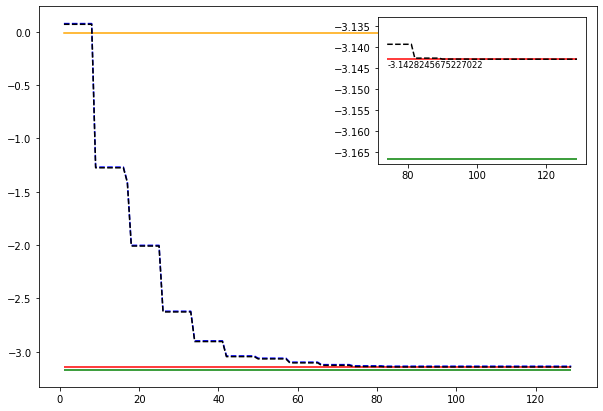

In [33]:
fig, ax = plt.subplots(figsize = (10, 7))

X=X_context
conv_diff = len(X_context) - len(X_noncon)

if conv_diff < 0:
    Y_noncon = Y_noncon[0:len(X)]
else:
    for i in range(conv_diff):
        Y_noncon.append(Y_noncon[-1])

Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]

ax.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
ax.plot(X, Y_context, color='blue', ls='--')
#plt.scatter(X, Y_total, color='black', marker = 'x')
ax.plot(X, Y_total, color='black', ls='--')

X_zoom = []
Y_zoom = []
for index, t in enumerate(Y_total):
    if t-0.01 < gs_noncon_energy:
        X_zoom.append(X[index])
        Y_zoom.append(t)

# location for the zoomed portion 
sub_axes = plt.axes([.596, .568, .29, .29]) 

# plot the zoomed portion
sub_axes.set_ylim((true_gs-0.001, gs_noncon_energy+0.01))
sub_axes.plot(X_zoom, Y_zoom, color='black', ls='--')
sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
sub_axes.text(X_zoom[0], Y_total[-1]-0.002, str(Y_total[-1]), size='small')

ax.hlines(gs_noncon_energy, 1, len(X), color='r')
ax.hlines(true_gs, 1, len(X), color='g')

target: -3.142824749268177
Removed generators: [] []
VQE result: -3.142824749268177 Improvement? False | Noncontextual: -3.142824749268177 True: -3.1667654772544127
target: -3.1428247492681756
Removed generators: ['ZIIIIIII'] [7]


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


VQE result: -3.1428247492640184 Improvement? False | Noncontextual: -3.142824749268177 True: -3.1667654772544127
target: -3.1518728818629804
Removed generators: ['IZIIIIII', 'ZIIIIIII'] [6, 7]
VQE result: -3.142824739987804 Improvement? False | Noncontextual: -3.142824749268177 True: -3.1667654772544127
target: -3.151872881862983
Removed generators: ['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 6, 7]
VQE result: -3.142824748540809 Improvement? False | Noncontextual: -3.142824749268177 True: -3.1667654772544127
target: -3.151872881862979
Removed generators: ['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 5, 6, 7]
VQE result: -3.1428247226129966 Improvement? False | Noncontextual: -3.142824749268177 True: -3.1667654772544127
target: -3.155710388287136
Removed generators: ['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 4, 5, 6, 7]
VQE result: -3.1428246368652566 Improvement? False | Noncontextual: -3.142824749268177 True: -3.1667654772544127
target: -3.1583354767662835
Re

KeyboardInterrupt: 

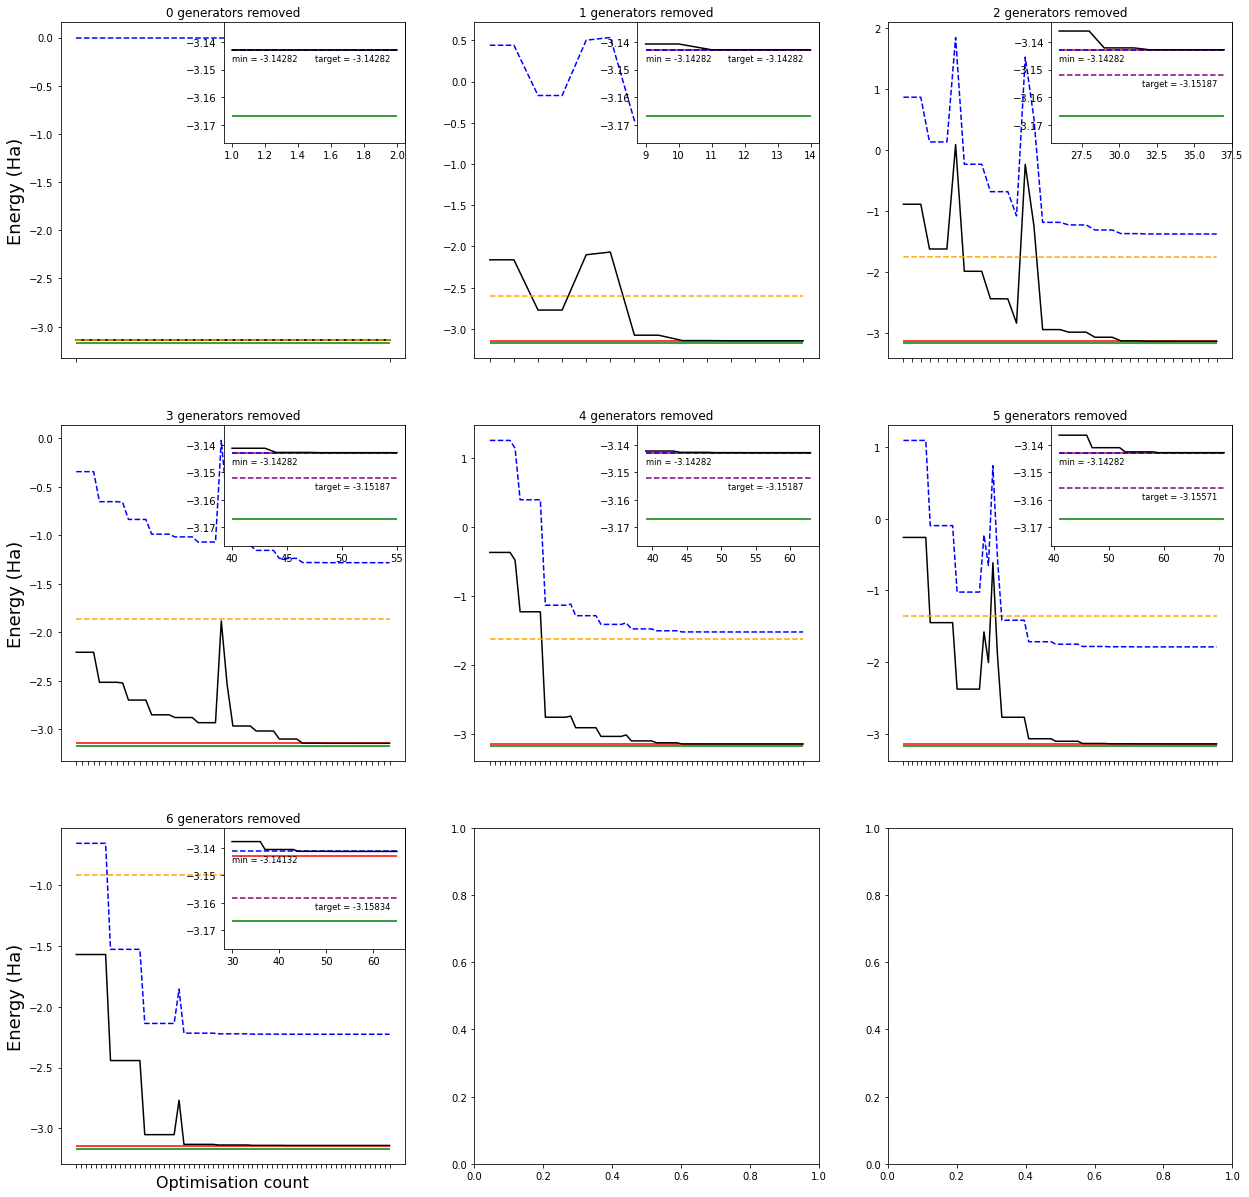

In [13]:
#VQE setup
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
slsqp = SLSQP(maxiter=10000)
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# create blank plot
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (21,21))
grid_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]

# compute +1-eigenspace quotient
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

# create blank parameters to assign in circuit for VQE optimsisation
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']
params = [] 
for comb in list(itertools.combinations(param_chars, 2)):
    char_str = ''.join(comb)
    params.append(Parameter(char_str))

#discard generators left to right whilst performing VQE
for index, grid in enumerate(grid_pos):
    if index == 0:
        target_energy = gs_noncon_energy
    else:
        ham_red_q = qonvert.dict_to_QubitOperator(ham_red[index-1])
        gs_red = get_ground_state(get_sparse_operator(ham_red_q, index).toarray())
        target_energy = gs_red[0]
    print('target:', target_energy)
    
    if grid == (2,2):
        print('Running full VQE routine...')
        #ucc_reversed=[]
        #for p in list(ucc.keys()):
        #    p_ref = list(deepcopy(p))
        #    p_ref.reverse()
        #    ucc_reversed.append(''.join(p_ref))
        #    #print(p_list)
        ##print(ucc_fix)
        #anz = c_anz.construct_ansatz(init_state = [4], paulis=ucc_reversed, trot_order=2)
        
        anz_terms = []
        for q in range(num_qubits):
            blank_op = ['I' for i in range(num_qubits)]
            blank_op[q] = 'Y'
            anz_terms.append(blank_op)
        
        anz = c_anz.construct_ansatz(init_state = [4], paulis=anz_terms, trot_order=2)
        
        vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
        vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(ham)
    
    else:
        removed_index = list(range(0, index))
        removed_index.reverse()
        removed_generators = [list(generators.keys())[i] for i in removed_index]
        Z_indices = [7 - g.find('Z') for g in removed_generators]

        print('Removed generators:', removed_generators, Z_indices)

        new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
        new_ham_noncon_add_q8={}
        new_ham_context_add_q8={}
        for p in new_ham_noncon.keys():
            p_add_q = 'I' + p
            new_ham_noncon_add_q8[p_add_q] = new_ham_noncon[p]
        for p in new_ham_context.keys():
            p_add_q = 'I' + p
            new_ham_context_add_q8[p_add_q] = new_ham_context[p]

        vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon_add_q8)
        vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context_add_q8)

        # initiate blank circuit
        anz=QuantumCircuit(num_qubits + 1)

        # noncontextual reference
        anz.x(4)

        # search over space not fixed by generators
        if Z_indices == []:
            anz.rz(params[0], 4) # because VQE needs at least one parameter...
        else:
            #param_index = 0
            #over_P = ['I' for i in range(num_qubits+1)]
            #for z in Z_indices:
            #    blank_P = ['I' for i in range(num_qubits+1)]
            #    blank_P[z] = 'X'
            #    over_P[z] = 'X'
            #    anz += c_anz.exp_P(''.join(blank_P), rot = params[param_index])
            #    anz += c_anz.exp_P(''.join(over_P), rot = params[param_index+1])
            #    param_index += 2
            
            anz_terms = []
            #q_hist = []
            for q in Z_indices:
                blank_op = ['I' for i in range(num_qubits+1)]
                blank_op[q] = 'Y'
                anz_terms.append(blank_op)
                #for p in q_hist:
                #    blank_op[p] = 'Y'
                #anz_terms.append(blank_op)
                #q_hist.append(q)
            
            anz = c_anz.construct_ansatz(init_state = [4], paulis=anz_terms, trot_order=2)
            
            #ucc_fix = []
            #Z_complement = list(set(range(num_qubits)) - set(Z_indices))
            ##print(Z_complement)
            #for p in ucc.keys():
            #    p_list = list(deepcopy(p))
            #    p_list.reverse()
            #    #p_list[6] = 'I'
            #    #p_list[7] = 'I'
            #    for z in Z_complement:     
            #        p_list[z] = 'I'
            #    ucc_fix.append(''.join(p_list) + 'I')
            #    #print(p_list)
            ##print(ucc_fix)
            #anz = c_anz.construct_ansatz(paulis=ucc_fix, circ=anz, trot_order=2)
            #anz = c_anz.construct_ansatz(paulis=ucc_fix, circ=anz, index_offset = 100) #2nd order trotterisation
            #anz += c_anz.exp_P('IIIYYIII', rot = Parameter('a'))
            #ent_map = list(itertools.combinations(range(num_qubits+1), 2))
            #anz += TwoLocal(no_q, 'ry', 'cx', ent_map, reps=2, insert_barriers=True)

        # store parity in auxiliary qubit (8) via CNOT cascade
        anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
        # move into +1-eigenspace
        anz.cry(2*t1, 8, 1)
        anz.x(8)
        anz.cry(2*t2, 8, 1)
        anz.x(8)
        # reverse CNOT cascade
        anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
        anz.x(1)
        #print(anz.draw())
    # create VQE routine
    vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

    # run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
    vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
    X_noncon = deepcopy(counts)
    Y_noncon = deepcopy(values)
    counts.clear(), values.clear()

    # run VQE on contextual hamiltonian
    vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
    X_context = deepcopy(counts)
    Y_context = deepcopy(values)
    counts.clear(), values.clear()
    
    # increase or decrease size of Y_noncon to match Y_context
    X=X_context
    conv_diff = len(X_context) - len(X_noncon)
    if conv_diff < 0:
        Y_noncon = Y_noncon[0:len(X)]
    else:
        for i in range(conv_diff):
            Y_noncon.append(Y_noncon[-1])
    
    # combined approximation
    if grid == (2,2):
        Y_total = Y_context
    else:
        Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]
    print('VQE result:', Y_total[-1], 'Improvement?', Y_total[-1]<gs_noncon_energy, '|', 'Noncontextual:', gs_noncon_energy, 'True:', true_gs)
            
    # plot results in corresponding subfigure
    axs[grid].plot(X, Y_total, color='black')
    #plt.plot(range(shots), Y_combined, color='purple')
    if grid != (2,2):
        axs[grid].plot(X, Y_noncon, color='orange',ls='--')
        #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
        axs[grid].plot(X, Y_context, color='blue', ls='--')
        #axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    
    axs[grid].hlines(gs_noncon_energy, 1, len(X), color='r')
    axs[grid].hlines(true_gs, 1, len(X), color='g')
    
    axs[grid].set_xticks(X)
    if grid == (2,2):
        axs[grid].set_title("Full VQE")
    else:  
        axs[grid].set_title("%i generators removed" % abs(index))
    axs[grid].set_xticklabels([])
    
    # plotting zoomed portion of graph to observe convergence
    X_zoom = []
    Y_zoom = []
    for index, t in enumerate(Y_total):
        if t-0.01 < gs_noncon_energy:
            X_zoom.append(X[index])
            Y_zoom.append(t)

    # location for the zoomed portion
    ax_box = axs[grid].get_position()
    ax_origin = (ax_box.get_points())[1]
    sf_size = 0.08
    sub_axes = plt.axes([ax_origin[0]-sf_size*1.5, ax_origin[1]-sf_size, sf_size*1.5, sf_size])

    # plot the zoomed portion
    sub_axes.set_ylim((true_gs-0.01, gs_noncon_energy+0.01))
    sub_axes.plot(X_zoom, Y_zoom, color='black')
    # lines fixed at noncontextual ground energy and true ground energy
    sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
    sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
    # plotting the target value given the number of qubits simulated
    sub_axes.hlines(target_energy, X_zoom[0], X_zoom[-1], color='purple', ls='--')
    sub_axes.text(x=median(X_zoom), y=target_energy-0.004, s= 'target = '+str(round(target_energy, 5)), size='small')
    # plotting the convergence value
    sub_axes.hlines(Y_zoom[-1], X_zoom[0], X_zoom[-1], color='b', ls='--')
    sub_axes.text(x=X_zoom[0], y=Y_total[-1]-0.004, s= 'min = '+str(round(Y_total[-1], 5)), size='small')
    
    
    if grid[0] == 2:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [ ]:
print(vqe_run_context)

In [103]:
fig.savefig("plots/HeH+-generator-removal-energies-VQE-uccsd_ansatz.png", dpi=300)

/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


[] [] [] [1]
Supported by noncontextual generator: [0, 1, 2, 3, 4, 5, 6, 7] , bits: [0, 0, 0, 1, 0, 0, 0, 0] , parity: 1
      ░ ┌─────────┐ ░  ░ ┌─────────┐ ░  ░ ┌─────┐┌───┐┌─────────┐┌───┐┌───┐ ░ »
q_0: ─░─┤ RZ(αβγ) ├─░──░─┤ RZ(αβδ) ├─░──░─┤ SDG ├┤ H ├┤ RZ(αβε) ├┤ H ├┤ S ├─░─»
      ░ └─────────┘ ░  ░ └─────────┘ ░  ░ └─────┘└───┘└─────────┘└───┘└───┘ ░ »
q_1: ─░─────────────░──░─────────────░──░───────────────────────────────────░─»
      ░             ░  ░             ░  ░                                   ░ »
«      ░ ┌───┐┌─────────┐┌───┐ ░  ░ ┌───┐┌─────────┐┌───┐ ░  ░ ┌─────┐┌───┐»
«q_0: ─░─┤ H ├┤ RZ(αβζ) ├┤ H ├─░──░─┤ H ├┤ RZ(αβη) ├┤ H ├─░──░─┤ SDG ├┤ H ├»
«      ░ └───┘└─────────┘└───┘ ░  ░ └───┘└─────────┘└───┘ ░  ░ └─────┘└───┘»
«q_1: ─░───────────────────────░──░───────────────────────░──░─────────────»
«      ░                       ░  ░                       ░  ░             »
«     ┌─────────┐┌───┐┌───┐ ░  ░ ┌───┐┌─────────┐┌───┐ ░  ░ ┌─────┐┌───┐»
«q_0: ┤ RZ(αβθ) ├┤ H

VQE: -3.1428245937067865 Target: -3.142824749268164 Error: 1.5556137755723398e-07


/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


['ZIIIIIII'] [0] [7] [7, 1]
Supported by noncontextual generator: [1, 2, 3, 4, 5, 6, 7] , bits: [0, 0, 1, 0, 0, 0, 0] , parity: 1
      ░                       ░  ░                       ░  ░ ┌─────┐┌───┐»
q_0: ─░───■───────────────■───░──░───■───────────────■───░──░─┤ SDG ├┤ H ├»
      ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░  ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░  ░ └─────┘└───┘»
q_1: ─░─┤ X ├┤ RZ(αβγ) ├┤ X ├─░──░─┤ X ├┤ RZ(αβδ) ├┤ X ├─░──░─────────────»
      ░ └───┘└─────────┘└───┘ ░  ░ └───┘└─────────┘└───┘ ░  ░             »
q_2: ─░───────────────────────░──░───────────────────────░──░─────────────»
      ░                       ░  ░                       ░  ░             »
«     ┌─────────┐┌───┐┌───┐ ░  ░ ┌───┐                     ┌───┐ ░  ░ ┌───┐»
«q_0: ┤ RZ(αβε) ├┤ H ├┤ S ├─░──░─┤ H ├──■───────────────■──┤ H ├─░──░─┤ H ├»
«     └─────────┘└───┘└───┘ ░  ░ └───┘┌─┴─┐┌─────────┐┌─┴─┐└───┘ ░  ░ └───┘»
«q_1: ──────────────────────░──░──────┤ X ├┤ RZ(αβζ) ├┤ X ├──────░──░──────»
«                           ░ 

VQE: -3.1518728255071715 Target: -3.1518728818629698 Error: 5.635579825025161e-08
['IZIIIIII', 'ZIIIIIII'] [1, 0] [6, 7] [7, 6, 1]
Supported by noncontextual generator: [2, 3, 4, 5, 6, 7] , bits: [0, 1, 0, 0, 0, 0] , parity: 1
      ░                       ░  ░                                 ░  ░ ┌─────┐»
q_0: ─░───■───────────────■───░──░───■─────────────────────────■───░──░─┤ SDG ├»
      ░   │               │   ░  ░ ┌─┴─┐                     ┌─┴─┐ ░  ░ └─────┘»
q_1: ─░───┼───────────────┼───░──░─┤ X ├──■───────────────■──┤ X ├─░──░────────»
      ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░  ░ └───┘┌─┴─┐┌─────────┐┌─┴─┐└───┘ ░  ░        »
q_2: ─░─┤ X ├┤ RZ(αβγ) ├┤ X ├─░──░──────┤ X ├┤ RZ(αβδ) ├┤ X ├──────░──░────────»
      ░ └───┘└─────────┘└───┘ ░  ░      └───┘└─────────┘└───┘      ░  ░        »
q_3: ─░───────────────────────░──░─────────────────────────────────░──░────────»
      ░                       ░  ░                                 ░  ░        »
«     ┌───┐┌─────────┐┌───┐┌───┐ ░  ░ ┌───┐ 

KeyboardInterrupt: 

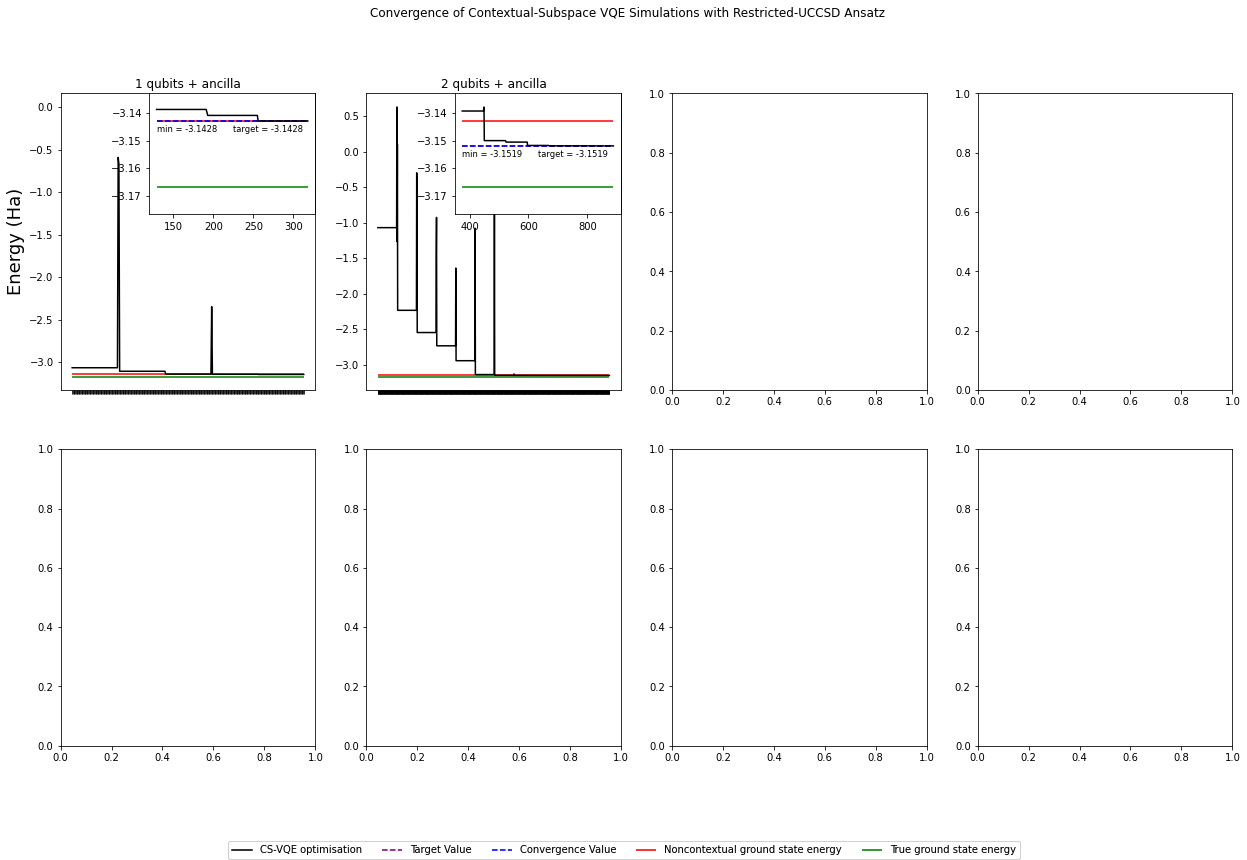

In [13]:
from qiskit.circuit.library import TwoLocal
noncon_state_list = [int(i) for i in list('00010000')]

#VQE setup
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
slsqp = SLSQP(maxiter=10000)
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# create blank plot
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
fig.suptitle('Convergence of Contextual-Subspace VQE Simulations with Restricted-UCCSD Ansatz')

grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]

# compute +1-eigenspace quotient
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

for index, h in enumerate(ham_red[0:-1]):
    grid = grid_pos[index]
    no_q = index + 1
    #print('ham:', h,'\n')
    h_q = qonvert.dict_to_QubitOperator(h)
    gs_red = get_ground_state(get_sparse_operator(h_q, no_q).toarray())
    target_energy = gs_red[0]
    

    h_add_anc={}
    for p in h.keys():
        p_add_q = 'I' + p
        h_add_anc[p_add_q] = h[p]
    vqe_red_ham_q = qonvert.dict_to_WeightedPauliOperator(h_add_anc)

    removed_index = list(range(0, index))
    removed_index.reverse()
    #print(removed_index)
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]    
    Z_qub_pos = [7-i for i in Z_indices]
    Z_qub_rev = [1] + deepcopy(Z_qub_pos)
    Z_qub_rev.reverse()
    Z_complement = list(set(range(num_qubits)) - set(Z_indices))
    print(removed_generators, Z_indices, Z_qub_pos, Z_qub_rev)

    anz = QuantumCircuit(no_q + 1)
    if 4 in Z_qub_pos:
        anz.x(no_q - 4)

    #anz.rz(params[0], 0)
    #for q in range(1, no_q):
    #    anz.rx(params[q], q)

    ucc_red_terms = []
    for i in list(ucc.keys()):
        blank_op = ['I' for i in range(no_q)]
        for index, q in enumerate([1] + Z_qub_pos):
            blank_op[index] = i[q]
        ucc_red_terms.append(''.join(blank_op) + 'I')
    #print(ucc_red_terms)
    anz += c_anz.construct_ansatz(paulis = ucc_red_terms, trot_order = 2)

    # compensate for parity of bits supported by remaining noncontextual generators
    q_sup = list(map(noncon_state_list.__getitem__, Z_complement))
    parity = sum(q_sup)%2
    print('Supported by noncontextual generator:', Z_complement, ', bits:', q_sup, ', parity:', parity)
    if parity:
        anz.x(no_q)

    cascade_bits = [q-7+index for q in Z_qub_pos if q in [2, 3, 4, 5, 6]] + [no_q]
    cb_index = list(range(len(cascade_bits)-1))
    #print('cascade qubits:', cascade_bits)
    for q in cb_index:
        anz.cx(cascade_bits[q], cascade_bits[q+1])

    anz.cry(2*t1, no_q, 0)
    anz.x(no_q)
    anz.cry(2*t2, no_q, 0)
    anz.x(no_q)
    anz.x(0)

    cb_index.reverse()
    for q in cb_index:
        anz.cx(cascade_bits[q], cascade_bits[q+1])

    print(anz.draw())
    
    vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)
    vqe_run    = vqe.compute_minimum_eigenvalue(operator=vqe_red_ham_q)
    vqe_result = vqe_run.optimal_value
    print('VQE:', vqe_result, 'Target:', target_energy, 'Error:', vqe_result - target_energy)
    
    vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)
    X = deepcopy(counts)
    Y = deepcopy(values)
    counts.clear(), values.clear()
    
    # plot results in corresponding subfigure
    l1 = axs[grid].plot(X, Y, color='black', zorder=2)
    l2 = axs[grid].hlines(gs_noncon_energy, X[0], X[-1], color='r', zorder=0)
    l3 = axs[grid].hlines(true_gs, X[0], X[-1], color='g', zorder=1)
    # creating legend labels for target and convergence value
    l4 = axs[grid].plot([1], [0], color='purple', ls='--', zorder=3)
    l5 = axs[grid].plot([1], [0], color='b', ls='--', zorder=4)

    
    axs[grid].set_xticks(X)
    if grid == (1,3):
        axs[grid].set_title("Full VQE")
    else:  
        axs[grid].set_title("%i qubits + ancilla" % int(index+1))
    axs[grid].set_xticklabels([])
    
    # plotting zoomed portion of graph to observe convergence
    X_zoom = []
    Y_zoom = []
    for index, t in enumerate(Y):
        if t-0.01 < gs_noncon_energy:
            X_zoom.append(X[index])
            Y_zoom.append(t)

    # location for the zoomed portion
    ax_box = axs[grid].get_position()
    ax_origin = (ax_box.get_points())[1]
    sf_size = 0.1
    sub_axes = plt.axes([ax_origin[0]-sf_size*1.1, ax_origin[1]-sf_size*1.4, sf_size*1.1, sf_size*1.4])

    # plot the zoomed portion
    sub_axes.set_ylim((true_gs-0.01, gs_noncon_energy+0.01))
    sub_axes.plot(X_zoom, Y_zoom, color='black')
    # lines fixed at noncontextual ground energy and true ground energy
    sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
    sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
    # plotting the target value given the number of qubits simulated
    sub_axes.hlines(target_energy, X_zoom[0], X_zoom[-1], color='purple', ls='--')
    sub_axes.text(x=median(X_zoom), y=target_energy-0.004, s= 'target = '+str(round(target_energy, 4)), size='small')
    # plotting the convergence value
    sub_axes.hlines(Y[-1], X_zoom[0], X_zoom[-1], color='b', ls='--')
    sub_axes.text(x=X_zoom[0], y=Y[-1]-0.004, s= 'min = '+str(round(Y[-1], 4)), size='small')
    
    if grid[0] == 1:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #ent_map = list(itertools.combinations(range(no_q), 2))
    #ansatz = TwoLocal(no_q, 'ry', 'cx', ent_map, reps=3, insert_barriers=True)
    fig.legend([l1,l2,l3,l4,l5],
               labels=['CS-VQE optimisation','Target Value','Convergence Value','Noncontextual ground state energy','True ground state energy'],
               loc="lower center",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               ncol=5)
    #vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)
    #vqe_run    = vqe.compute_minimum_eigenvalue(operator=vqe_red_ham_q)
    #vqe_result = vqe_run.optimal_value
    #print(vqe_result)

In [16]:
fig.savefig("plots/HeH+-generator-removal-energies-VQE-uccsd_ansatz_TEST.png", dpi=300)

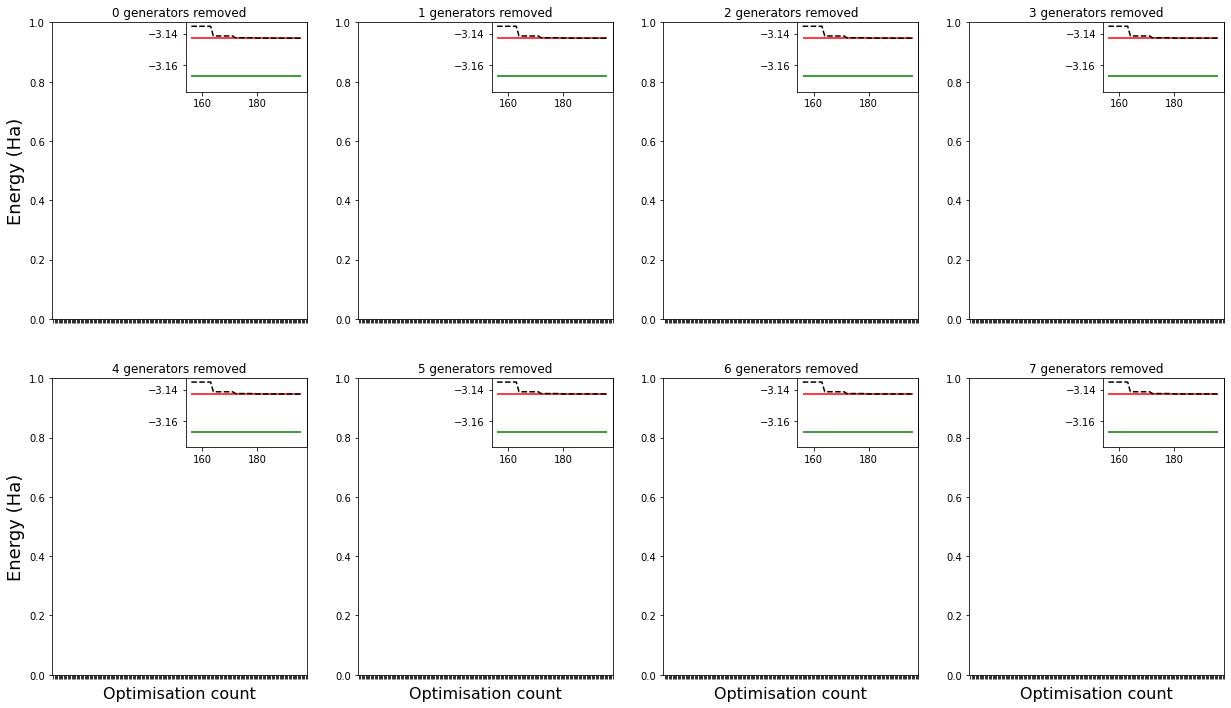

In [58]:
# create blank plot
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]

#discard generators left to right whilst performing VQE
for index, grid in enumerate(grid_pos):
    # plot results in corresponding subfigure
    #axs[grid].plot(X, Y_noncon, color='orange',ls='--')
    ##axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    #axs[grid].plot(X, Y_context, color='blue')
    ##axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    #axs[grid].plot(X, Y_total, color='black')
    ##plt.plot(range(shots), Y_combined, color='purple')
    #axs[grid].hlines(gs_noncon_energy, 1, len(X), color='r')
    #axs[grid].hlines(true_gs, 1, len(X), color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    axs[grid].set_xticklabels([])
    
    #X_zoom = []
    #Y_zoom = []
    #for index, t in enumerate(Y_total):
    #    if t-0.01 < gs_noncon_energy:
    #        X_zoom.append(X[index])
    #        Y_zoom.append(t)

    # location for the zoomed portion
    #x=(grid[0]+1)%2
    #y=grid[1]
    ax_box = axs[grid].get_position()
    ax_origin = (ax_box.get_points())[1]
    sf_size = 0.08
    sub_axes = plt.axes([ax_origin[0]-sf_size, ax_origin[1]-sf_size, sf_size, sf_size]) 
    
    # plot the zoomed portion
    sub_axes.set_ylim((true_gs-0.01, gs_noncon_energy+0.01))
    sub_axes.plot(X_zoom, Y_zoom, color='black', ls='--')
    sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
    sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
    
    
    if grid[0] == 1:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?



In [57]:
axs[grid].get_position()

Bbox([[0.7315217391304348, 0.1250000000000001], [0.9000000000000001, 0.46818181818181825]])

In [93]:
print()

In [52]:
median([0,3,6])

3

In [40]:
list(range(1))

[0]

In [52]:
lst = list(range(5))

In [57]:
lst[0:-1]

[0, 1, 2, 3]

In [26]:
removed_generators = ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII','IIIZIIII','IIIIZIII','IIIIIZII', 'IIIIIIIZ']
new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)

In [27]:
new_ham_noncon

{'IIIIIIII': (1.1324434021069392+0j), 'IIIIIIZI': (-1.1402165324907332+0j)}

In [11]:
import math
def factor_int(n):
    val = math.ceil(math.sqrt(n))
    val2 = int(n/val)
    while val2 * val != float(n):
        val -= 1
        val2 = int(n/val)
    
    if val > val2:
        val, val2 = val2, val
    return val, val2

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]


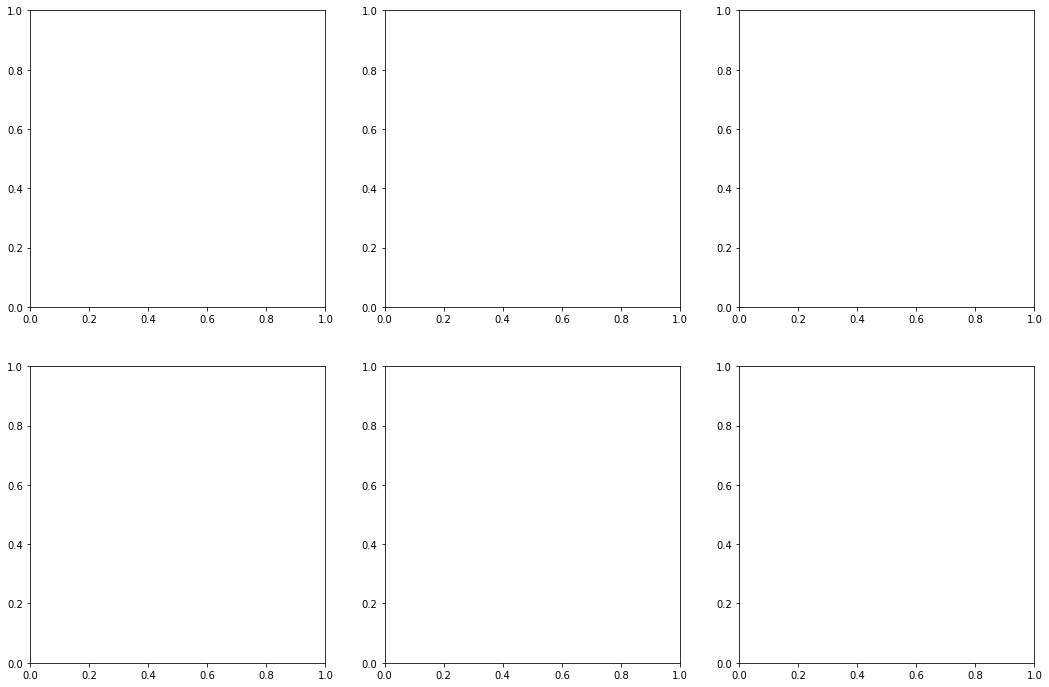

In [19]:
import matplotlib.pyplot as plt
import itertools
rows, cols = factor_int(6)
fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (6*cols,6*rows))
grid_pos = list(itertools.product(range(rows), range(cols)))
print(grid_pos)